# Tree Linearization on the XOR dataset

Some probes implemented in mislabeled rely on the assumption that the input estimator
is a linear model, to get explicit formulation for their derivatives with respect to
the input or coefficients.

In order to use these probes for model which are not linear (such as trees or MLPs),
we linearize them.

- for trees and ensembles, we train a surrogate linear model on the supervised kernel
  defined from the leaf indices where the input exemple falls in.
- for MLPs, the last hidden layer output features defines a supervised kernel,
  and the coefficients from the classification layer are used as a linear model.
- for linear models, this is a no-op.

In this notebook, we compute the self-influence of training data points for
different model families on a non-linearly separable dataset (XOR).


In [ ]:
import numpy as np
from joblib import delayed, Parallel
from matplotlib import pyplot as plt
from scipy.stats import kendalltau
from sklearn.base import clone
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import DecisionBoundaryDisplay


from mislabeled.probe import ApproximateLOO, NeuralRandomFeatures, NeuralTangentFeatures, TreeProjections, linearize
from mislabeled.probe._mlp import linearize_mlp_fisher, linearize_mlp_last_layer

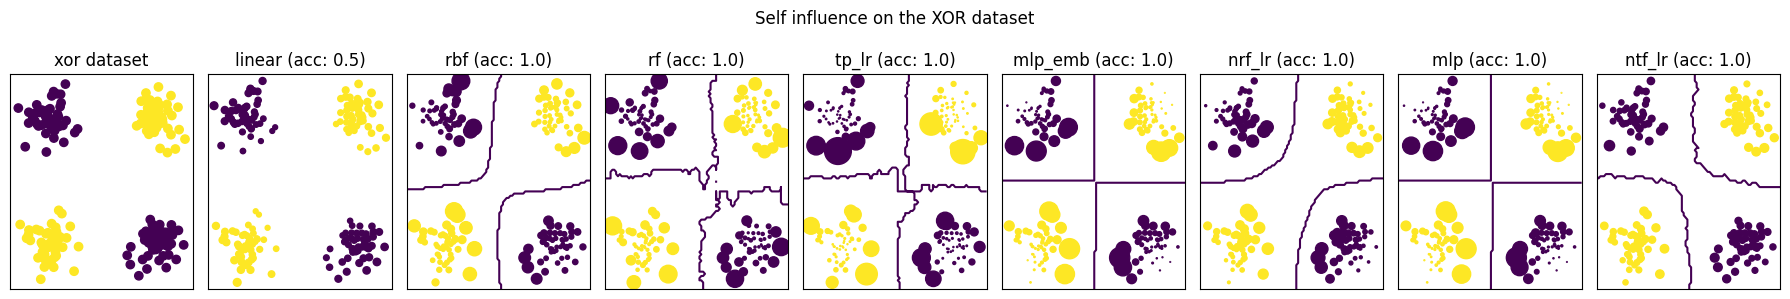

In [ ]:
X1, _ = make_blobs(centers=2, random_state=1)
X1 = StandardScaler().fit_transform(X1)
X = np.vstack((X1, X1 @ np.array([[0, -1], [1, 0]])))
y = np.hstack((np.ones(X1.shape[0]), np.zeros(X1.shape[0]))).astype(int)

models = dict(
    linear=LogisticRegression(random_state=1),
    rbf=make_pipeline(RBFSampler(random_state=1), LogisticRegression(random_state=1)),
    rf=(rf := ExtraTreesClassifier(max_depth=5, max_features=1, random_state=1)),
    tp_lr=make_pipeline(TreeProjections(rf), LogisticRegression(random_state=1)),
    mlp_emb=(mlp:=MLPClassifier(solver="lbfgs", random_state=1, alpha=1, activation="relu", tol=1e-6, max_iter=1000)),
    nrf_lr=make_pipeline(NeuralRandomFeatures(mlp, init=True), LogisticRegression(random_state=1)),
    mlp=mlp,
    ntf_lr=make_pipeline(NeuralTangentFeatures(mlp, init=True), LogisticRegression(random_state=1)),
)
probe = ApproximateLOO()

probes = dict()

fig, ax = plt.subplots(1, len(models) + 1, figsize=((len(models) + 1)*2, 3))


ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title("xor dataset")

for i, (name, model) in enumerate(models.items()):
    model.fit(X, y)
    score = model.score(X, y)
    if name == "mlp":
        linearize.register(type(model), linearize_mlp_fisher)
    probes[name] = probe(model, X, y)
    if name == "mlp":
        linearize.register(type(model), linearize_mlp_last_layer)
    ax[i + 1].scatter(
        X[:, 0], X[:, 1], c=y, s=20 * probes[name] / np.mean(probes[name])
    )
    ax[i + 1].set_xticks(())
    ax[i + 1].set_yticks(())
    ax[i + 1].set_title(f"{name} (acc: {score})")

    DecisionBoundaryDisplay.from_estimator(model, X, eps=0.1, ax=ax[i+1], plot_method="contour", response_method="predict", levels=[0])

fig.suptitle("Self influence on the XOR dataset")
plt.tight_layout()
plt.show()

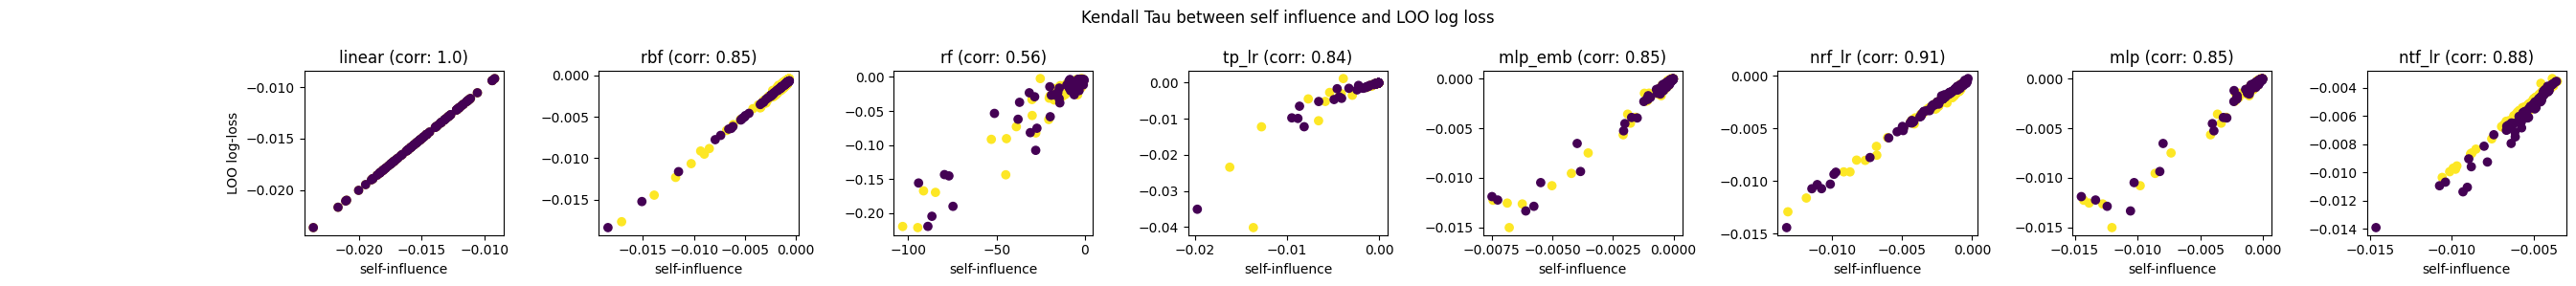

Exception ignored in: <function ResourceTracker.__del__ at 0x109275300>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10747d300>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.frame

In [ ]:
fig, ax = plt.subplots(1, len(models) + 1, figsize=((len(models) + 1)*3, 3))

ax[0].axis("off")
ax[1].set_ylabel("LOO log-loss")

def loss(y, p):
    return -(y * np.log(p) + (1-y)*np.log(1-p)).sum()

for i, (name, model) in enumerate(models.items()):

    model.fit(X, y)

    def eval(model, X, y, train, test):

        loo_ll_diff = loss(
            y[test],
            model.predict_proba(X[test])[:, 1],
        ) - loss(
            y[test],
            clone(model).fit(X[train], y[train]).predict_proba(X[test])[:, 1],
        )
        return loo_ll_diff
    
    loo_ll_diff = Parallel(n_jobs=-1)(
        delayed(eval)(model, X, y, train, test) for train, test in LeaveOneOut().split(X)
    )

    corr = kendalltau(probes[name], loo_ll_diff).statistic
    ax[i + 1].scatter(probes[name], loo_ll_diff, c=y)
    # min = np.min([ax[i + 1].get_xlim(), ax[i + 1].get_ylim()])
    # max = np.max([ax[i + 1].get_xlim(), ax[i + 1].get_ylim()])
    # ax[i + 1].set_xlim((min, max))
    # ax[i + 1].set_ylim((min, max))
    # ax[i + 1].axline((min, min), (max, max), color="black")
    ax[i + 1].set_xlabel("self-influence")
    ax[i + 1].set_title(f"{name} (corr: {round(corr,2)})")

fig.suptitle("Kendall Tau between self influence and LOO log loss")
plt.tight_layout()
plt.show()